# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)


Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

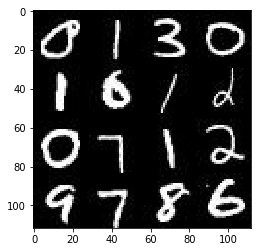

In [2]:
show_n_images = 17

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [3]:
test_im = mnist_images[0]
print(test_im.shape[0])

28


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

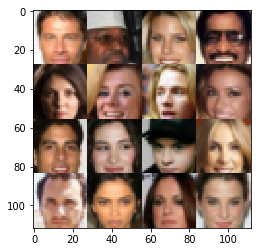

In [4]:
show_n_images = 22

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype = tf.float32, shape = (None,image_width, image_height, image_channels),name='real_input')
    z_input = tf.placeholder(dtype = tf.float32, shape = (None,z_dim),name='z_input')
    learning_rate = tf.placeholder(dtype = tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    use_bias = False
    kernel_size = 5
    strides = 2
    dropout_rate = 0.5
    do_print = False
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, filters = 64, kernel_size=kernel_size, strides=strides, padding = 'same', 
                              kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=True))# images_dim x images_dim x 64, where for these data sets images_dim = 28
        #b1 = tf.layers.batch_normalization(x1, training = True)
        r1 = tf.maximum(x1,x1*alpha)#leaky relu
        d1 = tf.layers.dropout(r1, rate=dropout_rate, training = True)
        if do_print: print('discriminator d1.shape={}'.format(d1.get_shape()))
        
        x2 = tf.layers.conv2d(d1, filters = 128, kernel_size=kernel_size, strides=strides, padding = 'same', 
                              kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=True), 
                              use_bias=use_bias)# dimensions are now (14 x 14 x 128)
        b2 = tf.layers.batch_normalization(x2, training = True)
        r2 = tf.maximum(b2, b2*alpha)
        d2 = tf.layers.dropout(r2, rate=dropout_rate, training = True)        
        if do_print: print('discriminator d2.shape={}'.format(d2.get_shape()))
        
        x3 = tf.layers.conv2d(d2, filters = 256, kernel_size=kernel_size, strides=strides, padding = 'same', 
                              kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=True),
                              use_bias=use_bias)
        b3 = tf.layers.batch_normalization(x3, training= True)
        r3 = tf.maximum(b3, b3*alpha)# dimensions of (7 x 7 x 256)
        d3 = tf.layers.dropout(r3, rate=dropout_rate, training = True)
        if do_print: print('discriminator d3.shape={}'.format(d3.get_shape()))

#         x4 = tf.layers.conv2d(r3, filters = 512, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer = tf.contrib.layers.xavier_initializer())
#         b4 = tf.layers.batch_normalization(x4, training = True)
#         r4 = tf.maximum(b4, b4*alpha)
        
        
        # Flatten
        flattened = tf.contrib.layers.flatten(d3)# This worked, but I'm not sure it's right...so I have put in the following based on assumption that images are dim of 28x28
        #flattened = tf.reshape(r3, (-1, 256*4*4))# if have no r4
#         flattened = tf.reshape(r4, (-1, 512*2*2))# if have r4
        #d4 = tf.layers.dropout(flattened, rate=dropout_rate, training = True)
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)
        
#         print('discriminator r1 shape=', r1.shape)
#         print('discriminator r2 shape =', r2.shape)
#         print('discriminator r3 shape =', r3.shape)
#         print('discriminator r4 shape =', r4.shape)
#         print('discriminator logits shape = ', logits.shape)

    return logits, output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_training = True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # 28, 14, 7
    use_bias = False
    init_dim = 2
    kernel_size = 5
    strides = 2
    dropout_rate = 0.0
    do_print = False
    with tf.variable_scope('generator', reuse= not is_training):
        
        # dim_new = dim_old + (dim_old-1)*(strides-1) + floor((kernel_size_old-1)/2) + ceil((kernel_size_old-1)/2)    
      
        #### Code for 3 layers 
        x0 = tf.layers.dense(z,units = 512*init_dim*init_dim, use_bias=use_bias)# 6x6x512
        x0 = tf.reshape(x0, (-1, init_dim, init_dim, 512))
        b0 = tf.layers.batch_normalization(x0, training = is_training)
        r0 = tf.maximum(b0, b0*alpha)
        d0 = tf.layers.dropout(r0, rate=dropout_rate, training = is_training)
        if do_print: print('generator d0.shape={}'.format(d0.get_shape()))
        
        x1 = tf.layers.conv2d_transpose(d0, filters = 256, kernel_size=kernel_size, strides=strides, padding = 'valid',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=True),
                                       use_bias=use_bias)
        b1 = tf.layers.batch_normalization(x1, training = is_training)
        r1 = tf.maximum(alpha*b1, b1)# ??? dimensions
        d1 = tf.layers.dropout(r1, rate=dropout_rate, training = is_training)
        if do_print: print('generator d1.shape={}'.format(d1.get_shape()))        
        
        x2 = tf.layers.conv2d_transpose(d1, filters = 128, kernel_size=kernel_size, strides=strides, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=True),
                                       use_bias=use_bias)
        b2 = tf.layers.batch_normalization(x2, training = is_training)
        r2 = tf.maximum(alpha*b2, b2)
        d2 = tf.layers.dropout(r2, rate=dropout_rate, training = is_training)
        if do_print: print('generator d2.shape={}'.format(d2.get_shape()))
           
        logits = tf.layers.conv2d_transpose(d2, filters = out_channel_dim, kernel_size=8, strides=2, padding='same',
                                            kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=True))#28x28xout_channel_dim
        if do_print: print('generator logits.shape={}'.format(logits.get_shape()))
        output = tf.tanh(logits)
        
        
        ############ Code for 4 layers
#         x0 = tf.layers.dense(z,units = 512*3*3)
#         x0 = tf.reshape(x0, (-1, 3, 3, 512))
#         b0 = tf.layers.batch_normalization(x0, training = is_training)
#         r0 = tf.maximum(b0, b0*alpha)
        
        
#         x1 = tf.layers.conv2d_transpose(r0, filters = 256, kernel_size = 5, strides = 2, padding = 'same')
#         b1 = tf.layers.batch_normalization(x1, training = is_training)
#         r1 = tf.maximum(alpha*b1, b1)# ??? dimensions
        
    
#         x2 = tf.layers.conv2d_transpose(r1, filters = 128, kernel_size = 2, strides = 1, padding='valid')
#         b2 = tf.layers.batch_normalization(x2, training=is_training)
#         r2 = tf.maximum(alpha*b2, b2)# 14x14x128
        
#         x3 = tf.layers.conv2d_transpose(r2, filters = 64, kernel_size = 5, strides = 2, padding = 'same')
#         b3 = tf.layers.batch_normalization(x3, training = is_training)
#         r3 = tf.maximum(alpha*b3, b3)
        
        
#         logits = tf.layers.conv2d_transpose(r3, filters = out_channel_dim, kernel_size = 5, strides = 2, padding = 'same')#28x28xout_channel_dim
#         output = tf.tanh(logits)
    
#         print('generator r0 shape = ', r0.shape)
#         print('generator r1 shape = ', r1.shape)
#         print('generator r2 shape=',r2.shape)
#         print('generator r3 shape=',r3.shape)
#         print('generator logits shape=', logits.shape)
        
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)
      

Tests Passed


generator r0 shape =  (?, 6, 6, 512)
generator r1 shape =  (?, 7, 7, 256)
generator r2 shape= (?, 14, 14, 128)
generator logits shape= (?, 28, 28, 5)
generator r0 shape =  (?, 6, 6, 512)
generator r1 shape =  (?, 7, 7, 256)
generator r2 shape= (?, 14, 14, 128)
generator logits shape= (?, 28, 28, 5)
Tests Passed

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_logits = generator(input_z, out_channel_dim, is_training = True, alpha = 0.2)
    d_real_logits, d_real_output = discriminator(input_real, reuse=False, alpha = 0.2)
    d_fake_logits, d_fake_output = discriminator(g_logits, reuse = True, alpha = 0.2)

    smooth = 0.1
    d_labels_real = tf.ones_like(d_real_output)*(1-smooth)
    d_labels_fake = tf.zeros_like(d_fake_output)
    g_labels = tf.ones_like(d_fake_output)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels = g_labels))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels = d_labels_fake))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_real_logits, labels = d_labels_real))
    
    d_loss = d_loss_fake + d_loss_real
    
    return g_loss, d_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_list = tf.trainable_variables()
    g_var_list = [v for v in t_list if v.name.startswith('generator')]
    d_var_list = [v for v in t_list if v.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list = g_var_list)
        d_train_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list = d_var_list)

    return g_train_optimizer, d_train_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    samples = []
    
    if data_image_mode == 'RGB':
        image_channels = 3
    else:
        image_channels = 1
        
    im_width = data_shape[1]
    im_height = data_shape[2]
        
    input_real, input_z, learn_rate = model_inputs(im_width, im_height, image_channels, z_dim)
    
    learn_rate = learning_rate
    g_loss, d_loss = model_loss(input_real, input_z, image_channels)
    g_opt, d_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    batch_count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
#                 print('batch_images_shape', batch_images.shape)
                # Random noise for z
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
#                 print('batch_z shape = ',batch_z.shape)
#                 batch_images = batch_images.reshape((batch_size, 784))
                batch_images = batch_images*2 #to rescale values between +-0.5 to +-1
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images, input_z: batch_z})
                
                # Show generator output
                if batch_count %100 == 0:
                    show_generator_output(sess, 4, input_z, image_channels, data_image_mode)
                batch_count +=1
                
                
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z:batch_z})
                print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                      "Discriminator loss: {:.4f}...".format(train_loss_d),
                      "Generator loss: {:.4f}".format(train_loss_g))
                losses.append((train_loss_d, train_loss_g))
        print('final generator loss = ', train_loss_g)
        print('final discriminator loss =', train_loss_d)
        print(len(losses))
        print(len([d[0] for d in losses]))
        pyplot.plot(range(len(losses)), [d[1] for d in losses],'--')
        pyplot.plot(range(len(losses)), [d[0] for d in losses],'-')     
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

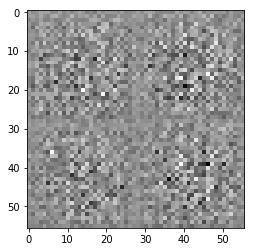

Epoch 1/2... Discriminator loss: 1.6145... Generator loss: 0.9350
Epoch 1/2... Discriminator loss: 1.7839... Generator loss: 0.8944
Epoch 1/2... Discriminator loss: 1.7495... Generator loss: 0.6193
Epoch 1/2... Discriminator loss: 1.5571... Generator loss: 0.6761
Epoch 1/2... Discriminator loss: 1.4251... Generator loss: 0.8208
Epoch 1/2... Discriminator loss: 1.5094... Generator loss: 0.8132
Epoch 1/2... Discriminator loss: 1.4163... Generator loss: 0.9350
Epoch 1/2... Discriminator loss: 1.0332... Generator loss: 1.4850
Epoch 1/2... Discriminator loss: 1.7654... Generator loss: 0.9524
Epoch 1/2... Discriminator loss: 1.3453... Generator loss: 0.9883
Epoch 1/2... Discriminator loss: 1.2804... Generator loss: 1.0336
Epoch 1/2... Discriminator loss: 1.5254... Generator loss: 0.8837
Epoch 1/2... Discriminator loss: 1.2757... Generator loss: 0.8442
Epoch 1/2... Discriminator loss: 1.3212... Generator loss: 1.4319
Epoch 1/2... Discriminator loss: 1.2102... Generator loss: 0.8422
Epoch 1/2.

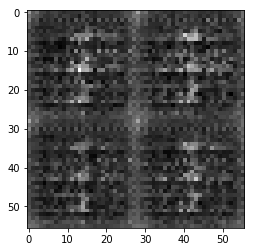

Epoch 1/2... Discriminator loss: 1.4000... Generator loss: 1.7355
Epoch 1/2... Discriminator loss: 1.1472... Generator loss: 1.1280
Epoch 1/2... Discriminator loss: 1.0017... Generator loss: 1.4020
Epoch 1/2... Discriminator loss: 1.0594... Generator loss: 1.7404
Epoch 1/2... Discriminator loss: 1.2651... Generator loss: 1.1653
Epoch 1/2... Discriminator loss: 1.2799... Generator loss: 1.2306
Epoch 1/2... Discriminator loss: 1.2390... Generator loss: 1.2871
Epoch 1/2... Discriminator loss: 1.4607... Generator loss: 0.9686
Epoch 1/2... Discriminator loss: 1.5415... Generator loss: 0.9969
Epoch 1/2... Discriminator loss: 1.7902... Generator loss: 1.3434
Epoch 1/2... Discriminator loss: 1.7382... Generator loss: 1.0067
Epoch 1/2... Discriminator loss: 1.5029... Generator loss: 1.6698
Epoch 1/2... Discriminator loss: 1.6317... Generator loss: 0.8531
Epoch 1/2... Discriminator loss: 1.6613... Generator loss: 1.1913
Epoch 1/2... Discriminator loss: 1.4344... Generator loss: 1.1585
Epoch 1/2.

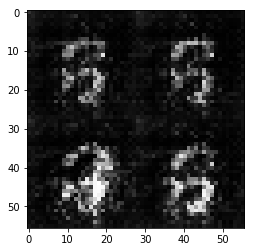

Epoch 1/2... Discriminator loss: 1.4107... Generator loss: 1.1805
Epoch 1/2... Discriminator loss: 1.2930... Generator loss: 1.6002
Epoch 1/2... Discriminator loss: 1.4002... Generator loss: 1.2353
Epoch 1/2... Discriminator loss: 1.7431... Generator loss: 1.0669
Epoch 1/2... Discriminator loss: 1.6887... Generator loss: 0.8099
Epoch 1/2... Discriminator loss: 1.4657... Generator loss: 1.5990
Epoch 1/2... Discriminator loss: 1.6057... Generator loss: 1.0766
Epoch 1/2... Discriminator loss: 1.2166... Generator loss: 1.4632
Epoch 1/2... Discriminator loss: 1.5053... Generator loss: 1.3481
Epoch 1/2... Discriminator loss: 1.4813... Generator loss: 1.3222
Epoch 1/2... Discriminator loss: 1.0972... Generator loss: 1.6097
Epoch 1/2... Discriminator loss: 1.1491... Generator loss: 1.4160
Epoch 1/2... Discriminator loss: 1.4463... Generator loss: 1.2836
Epoch 1/2... Discriminator loss: 1.3780... Generator loss: 1.7359
Epoch 1/2... Discriminator loss: 1.3943... Generator loss: 1.1319
Epoch 1/2.

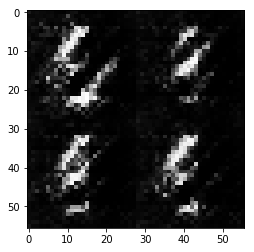

Epoch 1/2... Discriminator loss: 1.5651... Generator loss: 1.2177
Epoch 1/2... Discriminator loss: 1.5151... Generator loss: 1.4819
Epoch 1/2... Discriminator loss: 1.5466... Generator loss: 1.2965
Epoch 1/2... Discriminator loss: 1.5176... Generator loss: 1.0868
Epoch 1/2... Discriminator loss: 1.2600... Generator loss: 1.1936
Epoch 1/2... Discriminator loss: 1.4730... Generator loss: 1.5291
Epoch 1/2... Discriminator loss: 1.6003... Generator loss: 1.4870
Epoch 1/2... Discriminator loss: 1.5556... Generator loss: 1.0823
Epoch 1/2... Discriminator loss: 1.6116... Generator loss: 1.3147
Epoch 1/2... Discriminator loss: 1.5813... Generator loss: 1.1806
Epoch 1/2... Discriminator loss: 1.2641... Generator loss: 1.4985
Epoch 1/2... Discriminator loss: 1.2693... Generator loss: 1.8642
Epoch 1/2... Discriminator loss: 1.0739... Generator loss: 1.2845
Epoch 1/2... Discriminator loss: 1.0904... Generator loss: 1.5561
Epoch 1/2... Discriminator loss: 1.1310... Generator loss: 2.1307
Epoch 1/2.

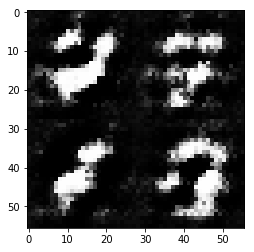

Epoch 1/2... Discriminator loss: 1.2815... Generator loss: 1.5684
Epoch 1/2... Discriminator loss: 1.0910... Generator loss: 1.3032
Epoch 1/2... Discriminator loss: 1.1370... Generator loss: 1.6616
Epoch 1/2... Discriminator loss: 1.2681... Generator loss: 1.7447
Epoch 1/2... Discriminator loss: 1.0798... Generator loss: 1.6820
Epoch 1/2... Discriminator loss: 1.4223... Generator loss: 1.3049
Epoch 1/2... Discriminator loss: 1.3300... Generator loss: 1.3122
Epoch 1/2... Discriminator loss: 1.3657... Generator loss: 1.2074
Epoch 1/2... Discriminator loss: 1.5972... Generator loss: 1.2976
Epoch 1/2... Discriminator loss: 1.4272... Generator loss: 1.0490
Epoch 1/2... Discriminator loss: 1.6048... Generator loss: 1.0334
Epoch 1/2... Discriminator loss: 1.3276... Generator loss: 1.2995
Epoch 1/2... Discriminator loss: 1.5450... Generator loss: 1.3103
Epoch 1/2... Discriminator loss: 1.4106... Generator loss: 1.6525
Epoch 1/2... Discriminator loss: 1.4084... Generator loss: 1.0674
Epoch 1/2.

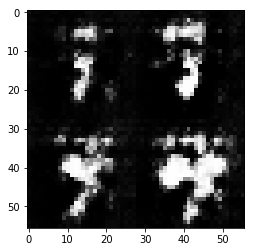

Epoch 1/2... Discriminator loss: 1.4075... Generator loss: 0.8643
Epoch 1/2... Discriminator loss: 1.3787... Generator loss: 1.4922
Epoch 1/2... Discriminator loss: 1.4343... Generator loss: 1.1054
Epoch 1/2... Discriminator loss: 1.0555... Generator loss: 1.4654
Epoch 1/2... Discriminator loss: 1.2062... Generator loss: 1.5552
Epoch 1/2... Discriminator loss: 1.3599... Generator loss: 1.3631
Epoch 1/2... Discriminator loss: 1.2481... Generator loss: 1.2900
Epoch 1/2... Discriminator loss: 1.2102... Generator loss: 1.9304
Epoch 1/2... Discriminator loss: 1.1520... Generator loss: 1.2425
Epoch 1/2... Discriminator loss: 1.0417... Generator loss: 1.3841
Epoch 1/2... Discriminator loss: 1.1691... Generator loss: 1.4268
Epoch 1/2... Discriminator loss: 1.0738... Generator loss: 1.3435
Epoch 1/2... Discriminator loss: 1.3304... Generator loss: 1.1313
Epoch 1/2... Discriminator loss: 1.4019... Generator loss: 1.2691
Epoch 1/2... Discriminator loss: 1.1748... Generator loss: 1.3918
Epoch 1/2.

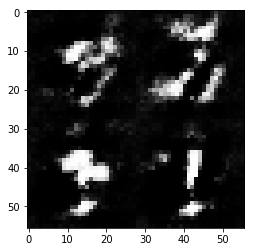

Epoch 1/2... Discriminator loss: 1.7144... Generator loss: 1.1077
Epoch 1/2... Discriminator loss: 1.3127... Generator loss: 0.9924
Epoch 1/2... Discriminator loss: 1.8084... Generator loss: 0.9940
Epoch 1/2... Discriminator loss: 1.9858... Generator loss: 1.4203
Epoch 1/2... Discriminator loss: 1.3542... Generator loss: 1.3540
Epoch 1/2... Discriminator loss: 1.4308... Generator loss: 0.9666
Epoch 1/2... Discriminator loss: 1.4738... Generator loss: 1.0901
Epoch 1/2... Discriminator loss: 1.2981... Generator loss: 1.1590
Epoch 1/2... Discriminator loss: 1.5458... Generator loss: 0.9864
Epoch 1/2... Discriminator loss: 1.2390... Generator loss: 1.3606
Epoch 1/2... Discriminator loss: 1.4412... Generator loss: 0.9058
Epoch 1/2... Discriminator loss: 1.6970... Generator loss: 1.3214
Epoch 1/2... Discriminator loss: 1.5790... Generator loss: 0.8746
Epoch 1/2... Discriminator loss: 1.4720... Generator loss: 1.1798
Epoch 1/2... Discriminator loss: 1.3776... Generator loss: 1.3964
Epoch 1/2.

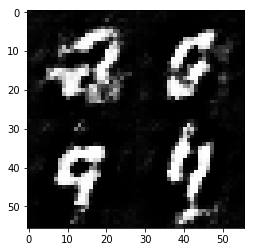

Epoch 1/2... Discriminator loss: 1.4646... Generator loss: 0.9664
Epoch 1/2... Discriminator loss: 1.6862... Generator loss: 1.1454
Epoch 1/2... Discriminator loss: 1.2452... Generator loss: 1.1547
Epoch 1/2... Discriminator loss: 1.1157... Generator loss: 1.4203
Epoch 1/2... Discriminator loss: 1.5677... Generator loss: 1.0937
Epoch 1/2... Discriminator loss: 1.4606... Generator loss: 1.2817
Epoch 1/2... Discriminator loss: 1.2752... Generator loss: 1.2800
Epoch 1/2... Discriminator loss: 1.3681... Generator loss: 1.0701
Epoch 1/2... Discriminator loss: 1.4140... Generator loss: 0.9958
Epoch 1/2... Discriminator loss: 1.5610... Generator loss: 1.1432
Epoch 1/2... Discriminator loss: 1.6026... Generator loss: 1.3088
Epoch 1/2... Discriminator loss: 1.5722... Generator loss: 1.4816
Epoch 1/2... Discriminator loss: 1.3308... Generator loss: 1.0742
Epoch 1/2... Discriminator loss: 1.5910... Generator loss: 1.0749
Epoch 1/2... Discriminator loss: 1.4674... Generator loss: 0.9460
Epoch 1/2.

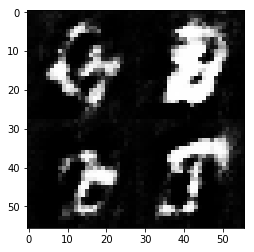

Epoch 1/2... Discriminator loss: 1.3500... Generator loss: 0.9368
Epoch 1/2... Discriminator loss: 1.2687... Generator loss: 1.0700
Epoch 1/2... Discriminator loss: 1.4650... Generator loss: 1.3130
Epoch 1/2... Discriminator loss: 1.6008... Generator loss: 0.8531
Epoch 1/2... Discriminator loss: 1.4759... Generator loss: 1.2156
Epoch 1/2... Discriminator loss: 1.3310... Generator loss: 0.9842
Epoch 1/2... Discriminator loss: 1.4739... Generator loss: 1.2372
Epoch 1/2... Discriminator loss: 1.4723... Generator loss: 1.1128
Epoch 1/2... Discriminator loss: 1.4194... Generator loss: 1.1492
Epoch 1/2... Discriminator loss: 1.3592... Generator loss: 1.0055
Epoch 1/2... Discriminator loss: 1.3101... Generator loss: 1.3235
Epoch 1/2... Discriminator loss: 1.4196... Generator loss: 1.1792
Epoch 1/2... Discriminator loss: 1.3764... Generator loss: 0.9762
Epoch 1/2... Discriminator loss: 1.6216... Generator loss: 1.2154
Epoch 1/2... Discriminator loss: 1.4419... Generator loss: 1.1035
Epoch 1/2.

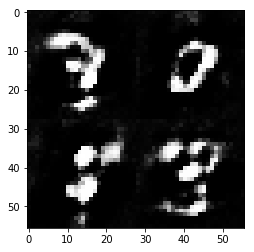

Epoch 1/2... Discriminator loss: 1.3130... Generator loss: 1.0427
Epoch 1/2... Discriminator loss: 1.4173... Generator loss: 1.2722
Epoch 1/2... Discriminator loss: 1.3920... Generator loss: 0.8319
Epoch 1/2... Discriminator loss: 1.3864... Generator loss: 0.9896
Epoch 1/2... Discriminator loss: 1.1392... Generator loss: 1.2719
Epoch 1/2... Discriminator loss: 1.4120... Generator loss: 0.7235
Epoch 1/2... Discriminator loss: 1.3276... Generator loss: 1.1818
Epoch 1/2... Discriminator loss: 1.3532... Generator loss: 1.2242
Epoch 1/2... Discriminator loss: 1.5772... Generator loss: 1.2040
Epoch 1/2... Discriminator loss: 1.2078... Generator loss: 1.0999
Epoch 1/2... Discriminator loss: 1.2127... Generator loss: 1.0572
Epoch 1/2... Discriminator loss: 1.1625... Generator loss: 1.0508
Epoch 1/2... Discriminator loss: 1.3158... Generator loss: 0.9767
Epoch 1/2... Discriminator loss: 1.2291... Generator loss: 0.9306
Epoch 1/2... Discriminator loss: 1.2688... Generator loss: 1.1244
Epoch 1/2.

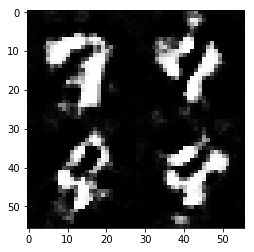

Epoch 1/2... Discriminator loss: 1.5548... Generator loss: 0.8855
Epoch 1/2... Discriminator loss: 1.5710... Generator loss: 1.3039
Epoch 1/2... Discriminator loss: 1.2883... Generator loss: 1.0706
Epoch 1/2... Discriminator loss: 1.5140... Generator loss: 1.1176
Epoch 1/2... Discriminator loss: 1.2416... Generator loss: 1.3314
Epoch 1/2... Discriminator loss: 1.3920... Generator loss: 1.2902
Epoch 1/2... Discriminator loss: 1.2747... Generator loss: 1.0355
Epoch 1/2... Discriminator loss: 1.2620... Generator loss: 1.2789
Epoch 1/2... Discriminator loss: 1.3763... Generator loss: 1.1897
Epoch 1/2... Discriminator loss: 1.0740... Generator loss: 1.1994
Epoch 1/2... Discriminator loss: 1.3633... Generator loss: 1.3043
Epoch 1/2... Discriminator loss: 1.1305... Generator loss: 1.0521
Epoch 1/2... Discriminator loss: 1.2695... Generator loss: 0.9937
Epoch 1/2... Discriminator loss: 1.4693... Generator loss: 1.5227
Epoch 1/2... Discriminator loss: 1.3195... Generator loss: 1.0420
Epoch 1/2.

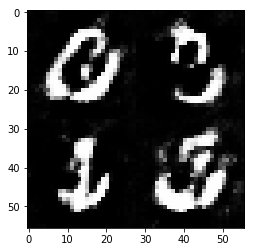

Epoch 1/2... Discriminator loss: 1.5660... Generator loss: 0.9354
Epoch 1/2... Discriminator loss: 1.2613... Generator loss: 0.8830
Epoch 1/2... Discriminator loss: 1.5638... Generator loss: 1.1658
Epoch 1/2... Discriminator loss: 1.3374... Generator loss: 1.1973
Epoch 1/2... Discriminator loss: 1.2151... Generator loss: 1.0874
Epoch 1/2... Discriminator loss: 1.5829... Generator loss: 0.8005
Epoch 1/2... Discriminator loss: 1.3906... Generator loss: 1.4094
Epoch 1/2... Discriminator loss: 1.3759... Generator loss: 1.0414
Epoch 1/2... Discriminator loss: 1.3120... Generator loss: 0.8031
Epoch 1/2... Discriminator loss: 1.1467... Generator loss: 0.9382
Epoch 1/2... Discriminator loss: 1.3006... Generator loss: 1.2571
Epoch 1/2... Discriminator loss: 1.3468... Generator loss: 0.8730
Epoch 1/2... Discriminator loss: 1.2005... Generator loss: 0.9945
Epoch 1/2... Discriminator loss: 1.3178... Generator loss: 1.0086
Epoch 1/2... Discriminator loss: 1.3466... Generator loss: 1.0473
Epoch 1/2.

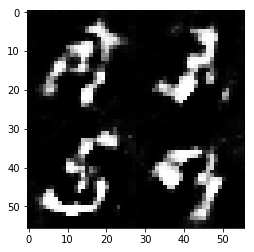

Epoch 1/2... Discriminator loss: 1.2558... Generator loss: 0.9119
Epoch 1/2... Discriminator loss: 1.5097... Generator loss: 1.2494
Epoch 1/2... Discriminator loss: 1.2789... Generator loss: 1.0026
Epoch 1/2... Discriminator loss: 1.3738... Generator loss: 1.3221
Epoch 1/2... Discriminator loss: 1.5814... Generator loss: 0.9660
Epoch 1/2... Discriminator loss: 1.3010... Generator loss: 1.1629
Epoch 1/2... Discriminator loss: 1.4147... Generator loss: 1.0166
Epoch 1/2... Discriminator loss: 1.2321... Generator loss: 0.9469
Epoch 1/2... Discriminator loss: 1.3556... Generator loss: 1.0357
Epoch 1/2... Discriminator loss: 1.2743... Generator loss: 0.9623
Epoch 1/2... Discriminator loss: 1.2892... Generator loss: 1.2583
Epoch 1/2... Discriminator loss: 1.3008... Generator loss: 0.8346
Epoch 1/2... Discriminator loss: 1.1586... Generator loss: 1.0124
Epoch 1/2... Discriminator loss: 1.1594... Generator loss: 0.9465
Epoch 1/2... Discriminator loss: 1.3700... Generator loss: 1.4505
Epoch 1/2.

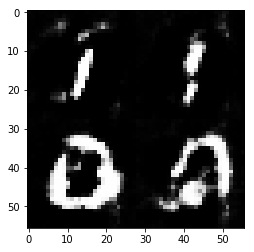

Epoch 1/2... Discriminator loss: 1.7454... Generator loss: 0.6418
Epoch 1/2... Discriminator loss: 1.2098... Generator loss: 1.1404
Epoch 1/2... Discriminator loss: 1.4161... Generator loss: 0.8704
Epoch 1/2... Discriminator loss: 1.2399... Generator loss: 1.3392
Epoch 1/2... Discriminator loss: 1.5160... Generator loss: 0.9512
Epoch 1/2... Discriminator loss: 1.3804... Generator loss: 1.0474
Epoch 1/2... Discriminator loss: 1.2657... Generator loss: 0.8311
Epoch 1/2... Discriminator loss: 1.1771... Generator loss: 1.0721
Epoch 1/2... Discriminator loss: 1.1850... Generator loss: 1.2150
Epoch 1/2... Discriminator loss: 1.1713... Generator loss: 1.0455
Epoch 1/2... Discriminator loss: 1.2496... Generator loss: 0.9036
Epoch 1/2... Discriminator loss: 1.3144... Generator loss: 1.3135
Epoch 1/2... Discriminator loss: 1.2102... Generator loss: 1.1810
Epoch 1/2... Discriminator loss: 1.2189... Generator loss: 1.2122
Epoch 1/2... Discriminator loss: 1.2950... Generator loss: 1.1831
Epoch 1/2.

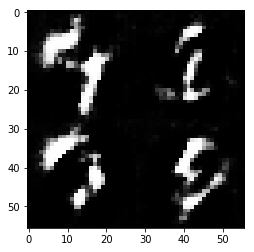

Epoch 1/2... Discriminator loss: 1.1586... Generator loss: 1.5228
Epoch 1/2... Discriminator loss: 1.4532... Generator loss: 0.8089
Epoch 1/2... Discriminator loss: 1.2066... Generator loss: 1.2489
Epoch 1/2... Discriminator loss: 1.3523... Generator loss: 1.0867
Epoch 1/2... Discriminator loss: 1.2970... Generator loss: 1.1645
Epoch 1/2... Discriminator loss: 1.3009... Generator loss: 1.0251
Epoch 1/2... Discriminator loss: 1.4015... Generator loss: 1.1450
Epoch 1/2... Discriminator loss: 1.2695... Generator loss: 0.9819
Epoch 1/2... Discriminator loss: 1.1738... Generator loss: 1.2947
Epoch 1/2... Discriminator loss: 1.3258... Generator loss: 1.0783
Epoch 1/2... Discriminator loss: 1.2701... Generator loss: 0.8940
Epoch 1/2... Discriminator loss: 1.3874... Generator loss: 1.0845
Epoch 1/2... Discriminator loss: 1.2323... Generator loss: 1.0390
Epoch 1/2... Discriminator loss: 1.2207... Generator loss: 0.8952
Epoch 1/2... Discriminator loss: 1.2019... Generator loss: 1.4168
Epoch 1/2.

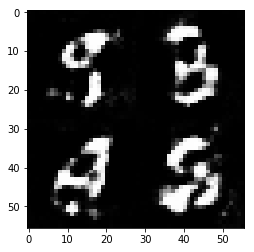

Epoch 1/2... Discriminator loss: 1.4925... Generator loss: 0.9740
Epoch 1/2... Discriminator loss: 1.3139... Generator loss: 1.1532
Epoch 1/2... Discriminator loss: 1.4352... Generator loss: 1.1545
Epoch 1/2... Discriminator loss: 1.2248... Generator loss: 1.1425
Epoch 1/2... Discriminator loss: 1.3060... Generator loss: 0.9905
Epoch 1/2... Discriminator loss: 1.3527... Generator loss: 1.1366
Epoch 1/2... Discriminator loss: 1.2798... Generator loss: 0.9496
Epoch 1/2... Discriminator loss: 1.3715... Generator loss: 0.9775
Epoch 1/2... Discriminator loss: 1.1589... Generator loss: 1.0177
Epoch 1/2... Discriminator loss: 1.3371... Generator loss: 0.9538
Epoch 1/2... Discriminator loss: 1.4698... Generator loss: 1.1132
Epoch 1/2... Discriminator loss: 1.3279... Generator loss: 1.0466
Epoch 1/2... Discriminator loss: 1.3155... Generator loss: 0.9356
Epoch 1/2... Discriminator loss: 1.2880... Generator loss: 0.9375
Epoch 1/2... Discriminator loss: 1.2512... Generator loss: 1.6070
Epoch 1/2.

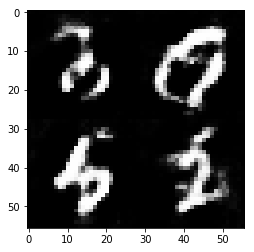

Epoch 1/2... Discriminator loss: 1.2955... Generator loss: 1.4327
Epoch 1/2... Discriminator loss: 1.3802... Generator loss: 0.6841
Epoch 1/2... Discriminator loss: 1.1191... Generator loss: 1.3981
Epoch 1/2... Discriminator loss: 1.2245... Generator loss: 1.4205
Epoch 1/2... Discriminator loss: 1.2042... Generator loss: 1.2235
Epoch 1/2... Discriminator loss: 1.3123... Generator loss: 0.8035
Epoch 1/2... Discriminator loss: 1.4154... Generator loss: 1.5921
Epoch 1/2... Discriminator loss: 1.0261... Generator loss: 0.8477
Epoch 1/2... Discriminator loss: 1.4477... Generator loss: 1.0930
Epoch 1/2... Discriminator loss: 1.2943... Generator loss: 0.8748
Epoch 1/2... Discriminator loss: 1.4448... Generator loss: 1.0379
Epoch 1/2... Discriminator loss: 1.2530... Generator loss: 0.8897
Epoch 1/2... Discriminator loss: 1.3948... Generator loss: 1.1223
Epoch 1/2... Discriminator loss: 1.2998... Generator loss: 1.2627
Epoch 1/2... Discriminator loss: 1.2784... Generator loss: 1.4795
Epoch 1/2.

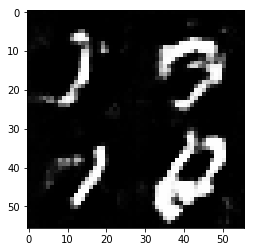

Epoch 1/2... Discriminator loss: 1.4520... Generator loss: 1.1621
Epoch 1/2... Discriminator loss: 1.2845... Generator loss: 0.7594
Epoch 1/2... Discriminator loss: 1.2905... Generator loss: 1.1451
Epoch 1/2... Discriminator loss: 1.3860... Generator loss: 1.2618
Epoch 1/2... Discriminator loss: 1.1681... Generator loss: 0.9051
Epoch 1/2... Discriminator loss: 1.4161... Generator loss: 1.4362
Epoch 1/2... Discriminator loss: 1.3398... Generator loss: 1.3978
Epoch 1/2... Discriminator loss: 1.0768... Generator loss: 1.0287
Epoch 1/2... Discriminator loss: 1.3708... Generator loss: 1.0044
Epoch 1/2... Discriminator loss: 1.5043... Generator loss: 1.0511
Epoch 1/2... Discriminator loss: 1.3302... Generator loss: 0.9687
Epoch 1/2... Discriminator loss: 1.1923... Generator loss: 1.4490
Epoch 1/2... Discriminator loss: 1.3675... Generator loss: 1.0910
Epoch 1/2... Discriminator loss: 1.3361... Generator loss: 1.0221
Epoch 1/2... Discriminator loss: 1.2734... Generator loss: 0.8811
Epoch 1/2.

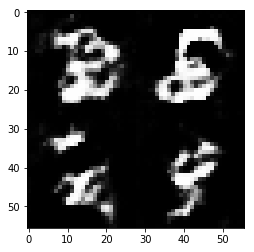

Epoch 1/2... Discriminator loss: 1.4127... Generator loss: 1.0616
Epoch 1/2... Discriminator loss: 1.3956... Generator loss: 0.8958
Epoch 1/2... Discriminator loss: 1.3200... Generator loss: 1.2380
Epoch 1/2... Discriminator loss: 1.2605... Generator loss: 1.2371
Epoch 1/2... Discriminator loss: 1.3559... Generator loss: 1.0531
Epoch 1/2... Discriminator loss: 1.2088... Generator loss: 1.0032
Epoch 1/2... Discriminator loss: 1.5120... Generator loss: 1.3089
Epoch 1/2... Discriminator loss: 1.2824... Generator loss: 1.4209
Epoch 1/2... Discriminator loss: 1.2658... Generator loss: 0.9835
Epoch 1/2... Discriminator loss: 1.3053... Generator loss: 1.1300
Epoch 1/2... Discriminator loss: 1.2875... Generator loss: 1.1169
Epoch 1/2... Discriminator loss: 1.2230... Generator loss: 1.0892
Epoch 1/2... Discriminator loss: 1.3410... Generator loss: 1.1336
Epoch 1/2... Discriminator loss: 1.3737... Generator loss: 0.9183
Epoch 1/2... Discriminator loss: 1.3077... Generator loss: 1.5702
Epoch 1/2.

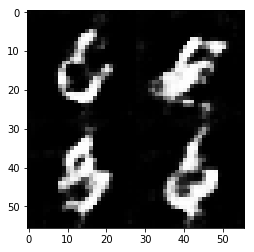

Epoch 2/2... Discriminator loss: 1.4417... Generator loss: 0.9764
Epoch 2/2... Discriminator loss: 1.4733... Generator loss: 0.8486
Epoch 2/2... Discriminator loss: 1.3952... Generator loss: 1.1319
Epoch 2/2... Discriminator loss: 1.3107... Generator loss: 0.8147
Epoch 2/2... Discriminator loss: 1.3629... Generator loss: 1.5506
Epoch 2/2... Discriminator loss: 1.3389... Generator loss: 0.7766
Epoch 2/2... Discriminator loss: 1.2560... Generator loss: 1.5763
Epoch 2/2... Discriminator loss: 1.4371... Generator loss: 0.8230
Epoch 2/2... Discriminator loss: 1.4208... Generator loss: 1.1718
Epoch 2/2... Discriminator loss: 1.2298... Generator loss: 0.8939
Epoch 2/2... Discriminator loss: 1.3013... Generator loss: 1.2148
Epoch 2/2... Discriminator loss: 1.5997... Generator loss: 0.8483
Epoch 2/2... Discriminator loss: 1.3566... Generator loss: 1.4200
Epoch 2/2... Discriminator loss: 1.2295... Generator loss: 0.9163
Epoch 2/2... Discriminator loss: 1.5263... Generator loss: 1.1998
Epoch 2/2.

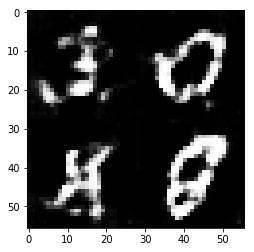

Epoch 2/2... Discriminator loss: 1.5482... Generator loss: 0.8076
Epoch 2/2... Discriminator loss: 1.3069... Generator loss: 1.1763
Epoch 2/2... Discriminator loss: 1.2775... Generator loss: 1.0766
Epoch 2/2... Discriminator loss: 1.3276... Generator loss: 1.0941
Epoch 2/2... Discriminator loss: 1.2532... Generator loss: 0.8544
Epoch 2/2... Discriminator loss: 1.1765... Generator loss: 1.1578
Epoch 2/2... Discriminator loss: 1.5849... Generator loss: 0.8893
Epoch 2/2... Discriminator loss: 1.4541... Generator loss: 1.3343
Epoch 2/2... Discriminator loss: 1.2466... Generator loss: 1.1417
Epoch 2/2... Discriminator loss: 1.3487... Generator loss: 1.4110
Epoch 2/2... Discriminator loss: 1.3565... Generator loss: 0.8534
Epoch 2/2... Discriminator loss: 1.1556... Generator loss: 1.2699
Epoch 2/2... Discriminator loss: 1.5896... Generator loss: 1.0904
Epoch 2/2... Discriminator loss: 1.2503... Generator loss: 1.0091
Epoch 2/2... Discriminator loss: 1.4343... Generator loss: 0.7414
Epoch 2/2.

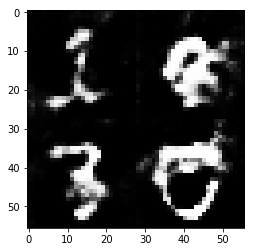

Epoch 2/2... Discriminator loss: 1.1445... Generator loss: 1.3440
Epoch 2/2... Discriminator loss: 1.2543... Generator loss: 1.1338
Epoch 2/2... Discriminator loss: 1.3203... Generator loss: 1.0188
Epoch 2/2... Discriminator loss: 1.3112... Generator loss: 1.0346
Epoch 2/2... Discriminator loss: 1.5382... Generator loss: 1.0186
Epoch 2/2... Discriminator loss: 1.5055... Generator loss: 0.8594
Epoch 2/2... Discriminator loss: 1.2783... Generator loss: 0.8779
Epoch 2/2... Discriminator loss: 1.2397... Generator loss: 0.8720
Epoch 2/2... Discriminator loss: 1.3319... Generator loss: 1.0018
Epoch 2/2... Discriminator loss: 1.3289... Generator loss: 1.3547
Epoch 2/2... Discriminator loss: 1.1554... Generator loss: 1.0779
Epoch 2/2... Discriminator loss: 1.2773... Generator loss: 1.1970
Epoch 2/2... Discriminator loss: 1.3154... Generator loss: 0.8677
Epoch 2/2... Discriminator loss: 1.4234... Generator loss: 1.0987
Epoch 2/2... Discriminator loss: 1.1357... Generator loss: 0.7981
Epoch 2/2.

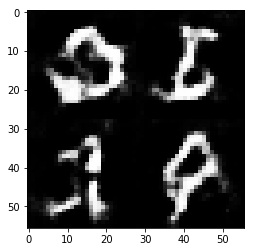

Epoch 2/2... Discriminator loss: 1.3260... Generator loss: 1.1860
Epoch 2/2... Discriminator loss: 1.5079... Generator loss: 1.1988
Epoch 2/2... Discriminator loss: 1.5481... Generator loss: 1.2304
Epoch 2/2... Discriminator loss: 1.3496... Generator loss: 0.8289
Epoch 2/2... Discriminator loss: 1.4286... Generator loss: 0.8782
Epoch 2/2... Discriminator loss: 1.2212... Generator loss: 1.1489
Epoch 2/2... Discriminator loss: 1.3412... Generator loss: 1.0838
Epoch 2/2... Discriminator loss: 1.4375... Generator loss: 1.0309
Epoch 2/2... Discriminator loss: 1.2727... Generator loss: 0.8664
Epoch 2/2... Discriminator loss: 1.2959... Generator loss: 1.2839
Epoch 2/2... Discriminator loss: 1.2852... Generator loss: 0.7876
Epoch 2/2... Discriminator loss: 1.5393... Generator loss: 0.8477
Epoch 2/2... Discriminator loss: 1.2283... Generator loss: 0.9451
Epoch 2/2... Discriminator loss: 1.2932... Generator loss: 1.2337
Epoch 2/2... Discriminator loss: 1.5014... Generator loss: 0.9925
Epoch 2/2.

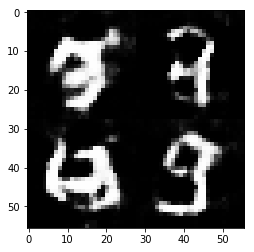

Epoch 2/2... Discriminator loss: 1.2617... Generator loss: 1.1866
Epoch 2/2... Discriminator loss: 1.6456... Generator loss: 0.7567
Epoch 2/2... Discriminator loss: 1.1109... Generator loss: 0.8439
Epoch 2/2... Discriminator loss: 1.3914... Generator loss: 0.8733
Epoch 2/2... Discriminator loss: 1.3366... Generator loss: 1.2428
Epoch 2/2... Discriminator loss: 1.1275... Generator loss: 0.8507
Epoch 2/2... Discriminator loss: 1.2732... Generator loss: 1.0109
Epoch 2/2... Discriminator loss: 1.1928... Generator loss: 0.9841
Epoch 2/2... Discriminator loss: 1.2813... Generator loss: 1.1085
Epoch 2/2... Discriminator loss: 1.3374... Generator loss: 1.0008
Epoch 2/2... Discriminator loss: 1.3121... Generator loss: 0.9992
Epoch 2/2... Discriminator loss: 1.3411... Generator loss: 1.1324
Epoch 2/2... Discriminator loss: 1.3122... Generator loss: 0.9754
Epoch 2/2... Discriminator loss: 1.4675... Generator loss: 1.0427
Epoch 2/2... Discriminator loss: 1.2214... Generator loss: 0.9457
Epoch 2/2.

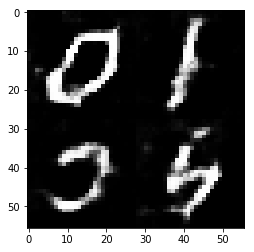

Epoch 2/2... Discriminator loss: 1.3901... Generator loss: 0.8873
Epoch 2/2... Discriminator loss: 1.2085... Generator loss: 1.1830
Epoch 2/2... Discriminator loss: 1.2439... Generator loss: 1.1604
Epoch 2/2... Discriminator loss: 1.2802... Generator loss: 0.9668
Epoch 2/2... Discriminator loss: 1.2533... Generator loss: 1.0331
Epoch 2/2... Discriminator loss: 1.2389... Generator loss: 1.1665
Epoch 2/2... Discriminator loss: 1.2182... Generator loss: 0.9809
Epoch 2/2... Discriminator loss: 1.3815... Generator loss: 1.0326
Epoch 2/2... Discriminator loss: 1.3409... Generator loss: 1.0113
Epoch 2/2... Discriminator loss: 1.2197... Generator loss: 1.2099
Epoch 2/2... Discriminator loss: 1.4683... Generator loss: 0.9033
Epoch 2/2... Discriminator loss: 1.3959... Generator loss: 1.5177
Epoch 2/2... Discriminator loss: 1.2605... Generator loss: 0.9108
Epoch 2/2... Discriminator loss: 1.2490... Generator loss: 0.9876
Epoch 2/2... Discriminator loss: 1.4057... Generator loss: 0.7217
Epoch 2/2.

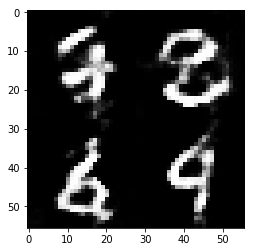

Epoch 2/2... Discriminator loss: 1.5559... Generator loss: 0.9733
Epoch 2/2... Discriminator loss: 1.4850... Generator loss: 1.2723
Epoch 2/2... Discriminator loss: 1.3024... Generator loss: 0.7274
Epoch 2/2... Discriminator loss: 1.4629... Generator loss: 1.0966
Epoch 2/2... Discriminator loss: 1.3124... Generator loss: 1.0500
Epoch 2/2... Discriminator loss: 1.3629... Generator loss: 1.2430
Epoch 2/2... Discriminator loss: 1.2924... Generator loss: 0.6809
Epoch 2/2... Discriminator loss: 1.3715... Generator loss: 0.8957
Epoch 2/2... Discriminator loss: 1.3303... Generator loss: 0.8628
Epoch 2/2... Discriminator loss: 1.3860... Generator loss: 1.1943
Epoch 2/2... Discriminator loss: 1.2810... Generator loss: 0.8580
Epoch 2/2... Discriminator loss: 1.3599... Generator loss: 1.2409
Epoch 2/2... Discriminator loss: 1.2381... Generator loss: 0.9889
Epoch 2/2... Discriminator loss: 1.2604... Generator loss: 1.2494
Epoch 2/2... Discriminator loss: 1.3664... Generator loss: 0.8397
Epoch 2/2.

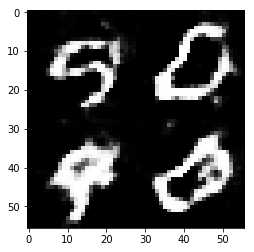

Epoch 2/2... Discriminator loss: 1.3972... Generator loss: 1.2478
Epoch 2/2... Discriminator loss: 1.4544... Generator loss: 0.7386
Epoch 2/2... Discriminator loss: 1.3205... Generator loss: 1.0377
Epoch 2/2... Discriminator loss: 1.5020... Generator loss: 0.6846
Epoch 2/2... Discriminator loss: 1.4292... Generator loss: 1.1697
Epoch 2/2... Discriminator loss: 1.2086... Generator loss: 0.6146
Epoch 2/2... Discriminator loss: 1.4633... Generator loss: 0.9188
Epoch 2/2... Discriminator loss: 1.1950... Generator loss: 1.1058
Epoch 2/2... Discriminator loss: 1.1514... Generator loss: 1.0888
Epoch 2/2... Discriminator loss: 1.3385... Generator loss: 0.9387
Epoch 2/2... Discriminator loss: 1.2650... Generator loss: 0.8477
Epoch 2/2... Discriminator loss: 1.2481... Generator loss: 0.8332
Epoch 2/2... Discriminator loss: 1.2368... Generator loss: 1.2844
Epoch 2/2... Discriminator loss: 1.2380... Generator loss: 0.6819
Epoch 2/2... Discriminator loss: 1.5742... Generator loss: 1.1947
Epoch 2/2.

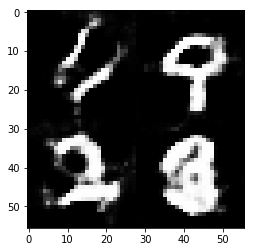

Epoch 2/2... Discriminator loss: 1.4176... Generator loss: 1.2876
Epoch 2/2... Discriminator loss: 1.2995... Generator loss: 0.9174
Epoch 2/2... Discriminator loss: 1.2901... Generator loss: 1.1751
Epoch 2/2... Discriminator loss: 1.4463... Generator loss: 0.6716
Epoch 2/2... Discriminator loss: 1.3462... Generator loss: 1.1929
Epoch 2/2... Discriminator loss: 1.3496... Generator loss: 0.6998
Epoch 2/2... Discriminator loss: 0.9774... Generator loss: 1.3448
Epoch 2/2... Discriminator loss: 1.2433... Generator loss: 0.8372
Epoch 2/2... Discriminator loss: 1.3312... Generator loss: 1.1154
Epoch 2/2... Discriminator loss: 1.4128... Generator loss: 1.0024
Epoch 2/2... Discriminator loss: 1.3599... Generator loss: 0.8229
Epoch 2/2... Discriminator loss: 1.3150... Generator loss: 1.0511
Epoch 2/2... Discriminator loss: 1.2501... Generator loss: 1.1005
Epoch 2/2... Discriminator loss: 1.2481... Generator loss: 0.9426
Epoch 2/2... Discriminator loss: 1.4295... Generator loss: 1.3346
Epoch 2/2.

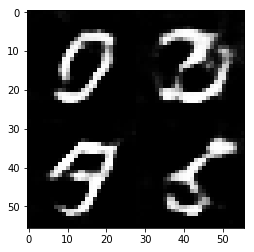

Epoch 2/2... Discriminator loss: 1.3083... Generator loss: 0.9901
Epoch 2/2... Discriminator loss: 1.2102... Generator loss: 1.0109
Epoch 2/2... Discriminator loss: 1.4053... Generator loss: 0.9467
Epoch 2/2... Discriminator loss: 1.1981... Generator loss: 0.8974
Epoch 2/2... Discriminator loss: 1.2294... Generator loss: 1.1796
Epoch 2/2... Discriminator loss: 1.2933... Generator loss: 0.8833
Epoch 2/2... Discriminator loss: 1.2803... Generator loss: 0.7759
Epoch 2/2... Discriminator loss: 1.3800... Generator loss: 1.0620
Epoch 2/2... Discriminator loss: 1.2640... Generator loss: 1.0398
Epoch 2/2... Discriminator loss: 1.3083... Generator loss: 0.9705
Epoch 2/2... Discriminator loss: 1.4425... Generator loss: 1.0871
Epoch 2/2... Discriminator loss: 1.2693... Generator loss: 1.0732
Epoch 2/2... Discriminator loss: 1.3083... Generator loss: 0.9356
Epoch 2/2... Discriminator loss: 1.2998... Generator loss: 1.0554
Epoch 2/2... Discriminator loss: 1.2518... Generator loss: 1.1305
Epoch 2/2.

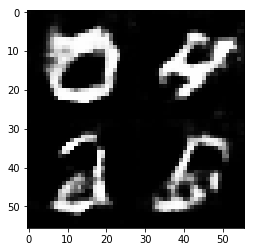

Epoch 2/2... Discriminator loss: 1.2190... Generator loss: 1.0697
Epoch 2/2... Discriminator loss: 1.4000... Generator loss: 0.9295
Epoch 2/2... Discriminator loss: 1.2871... Generator loss: 1.0239
Epoch 2/2... Discriminator loss: 1.2342... Generator loss: 0.9689
Epoch 2/2... Discriminator loss: 1.3131... Generator loss: 1.1485
Epoch 2/2... Discriminator loss: 1.1760... Generator loss: 0.8347
Epoch 2/2... Discriminator loss: 1.4651... Generator loss: 0.8205
Epoch 2/2... Discriminator loss: 1.4318... Generator loss: 0.9548
Epoch 2/2... Discriminator loss: 1.2845... Generator loss: 1.0354
Epoch 2/2... Discriminator loss: 1.4744... Generator loss: 1.1841
Epoch 2/2... Discriminator loss: 1.3991... Generator loss: 0.9693
Epoch 2/2... Discriminator loss: 1.3769... Generator loss: 1.1528
Epoch 2/2... Discriminator loss: 1.3390... Generator loss: 0.7356
Epoch 2/2... Discriminator loss: 1.4320... Generator loss: 1.1166
Epoch 2/2... Discriminator loss: 1.3941... Generator loss: 1.0988
Epoch 2/2.

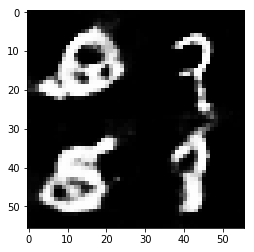

Epoch 2/2... Discriminator loss: 1.2434... Generator loss: 1.0151
Epoch 2/2... Discriminator loss: 1.1329... Generator loss: 0.8110
Epoch 2/2... Discriminator loss: 1.4052... Generator loss: 0.8545
Epoch 2/2... Discriminator loss: 1.2528... Generator loss: 1.1948
Epoch 2/2... Discriminator loss: 1.3720... Generator loss: 1.1239
Epoch 2/2... Discriminator loss: 1.3914... Generator loss: 0.8352
Epoch 2/2... Discriminator loss: 1.3402... Generator loss: 0.9496
Epoch 2/2... Discriminator loss: 1.3579... Generator loss: 1.0992
Epoch 2/2... Discriminator loss: 1.2360... Generator loss: 0.9063
Epoch 2/2... Discriminator loss: 1.4515... Generator loss: 0.9611
Epoch 2/2... Discriminator loss: 1.3009... Generator loss: 0.9714
Epoch 2/2... Discriminator loss: 1.3119... Generator loss: 0.7167
Epoch 2/2... Discriminator loss: 1.1540... Generator loss: 1.0137
Epoch 2/2... Discriminator loss: 1.1632... Generator loss: 1.1006
Epoch 2/2... Discriminator loss: 1.4887... Generator loss: 0.9634
Epoch 2/2.

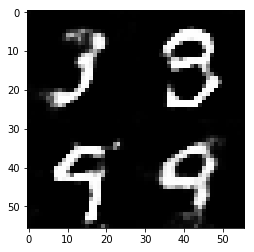

Epoch 2/2... Discriminator loss: 1.3139... Generator loss: 0.9675
Epoch 2/2... Discriminator loss: 1.2104... Generator loss: 0.9733
Epoch 2/2... Discriminator loss: 1.2019... Generator loss: 0.8277
Epoch 2/2... Discriminator loss: 1.4258... Generator loss: 1.2556
Epoch 2/2... Discriminator loss: 1.3346... Generator loss: 0.7747
Epoch 2/2... Discriminator loss: 1.5124... Generator loss: 1.0478
Epoch 2/2... Discriminator loss: 1.5120... Generator loss: 0.8535
Epoch 2/2... Discriminator loss: 1.3477... Generator loss: 1.0526
Epoch 2/2... Discriminator loss: 1.2953... Generator loss: 0.7445
Epoch 2/2... Discriminator loss: 1.3519... Generator loss: 0.9104
Epoch 2/2... Discriminator loss: 1.1939... Generator loss: 1.0574
Epoch 2/2... Discriminator loss: 1.2330... Generator loss: 0.8405
Epoch 2/2... Discriminator loss: 1.3751... Generator loss: 1.1398
Epoch 2/2... Discriminator loss: 1.2111... Generator loss: 1.1404
Epoch 2/2... Discriminator loss: 1.4547... Generator loss: 0.6943
Epoch 2/2.

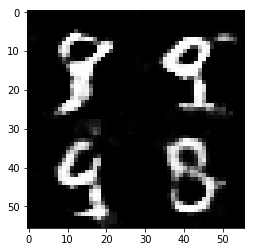

Epoch 2/2... Discriminator loss: 1.2983... Generator loss: 0.9413
Epoch 2/2... Discriminator loss: 1.3498... Generator loss: 0.9268
Epoch 2/2... Discriminator loss: 1.3833... Generator loss: 0.6804
Epoch 2/2... Discriminator loss: 1.2783... Generator loss: 1.1995
Epoch 2/2... Discriminator loss: 1.4755... Generator loss: 0.8017
Epoch 2/2... Discriminator loss: 1.2421... Generator loss: 0.8672
Epoch 2/2... Discriminator loss: 1.2813... Generator loss: 0.8936
Epoch 2/2... Discriminator loss: 1.3475... Generator loss: 0.9672
Epoch 2/2... Discriminator loss: 1.2478... Generator loss: 0.8112
Epoch 2/2... Discriminator loss: 1.2968... Generator loss: 1.1861
Epoch 2/2... Discriminator loss: 1.2169... Generator loss: 0.7546
Epoch 2/2... Discriminator loss: 1.2729... Generator loss: 1.0981
Epoch 2/2... Discriminator loss: 1.3668... Generator loss: 0.8005
Epoch 2/2... Discriminator loss: 1.3951... Generator loss: 0.8868
Epoch 2/2... Discriminator loss: 1.4861... Generator loss: 0.7093
Epoch 2/2.

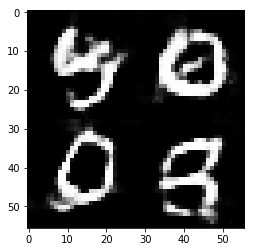

Epoch 2/2... Discriminator loss: 1.2671... Generator loss: 1.0082
Epoch 2/2... Discriminator loss: 1.2477... Generator loss: 0.9044
Epoch 2/2... Discriminator loss: 1.1656... Generator loss: 0.8748
Epoch 2/2... Discriminator loss: 1.2504... Generator loss: 0.8583
Epoch 2/2... Discriminator loss: 1.3358... Generator loss: 0.9716
Epoch 2/2... Discriminator loss: 1.2886... Generator loss: 0.9791
Epoch 2/2... Discriminator loss: 1.3883... Generator loss: 0.7538
Epoch 2/2... Discriminator loss: 1.2729... Generator loss: 0.9402
Epoch 2/2... Discriminator loss: 1.2912... Generator loss: 0.8677
Epoch 2/2... Discriminator loss: 1.6232... Generator loss: 1.2617
Epoch 2/2... Discriminator loss: 1.2210... Generator loss: 1.0831
Epoch 2/2... Discriminator loss: 1.2088... Generator loss: 1.0757
Epoch 2/2... Discriminator loss: 1.2680... Generator loss: 1.1911
Epoch 2/2... Discriminator loss: 1.3796... Generator loss: 0.7598
Epoch 2/2... Discriminator loss: 1.3629... Generator loss: 1.2202
Epoch 2/2.

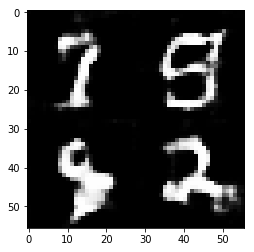

Epoch 2/2... Discriminator loss: 1.3126... Generator loss: 1.0690
Epoch 2/2... Discriminator loss: 1.1728... Generator loss: 0.8015
Epoch 2/2... Discriminator loss: 1.2179... Generator loss: 0.8664
Epoch 2/2... Discriminator loss: 1.3792... Generator loss: 1.0260
Epoch 2/2... Discriminator loss: 1.3341... Generator loss: 0.9272
Epoch 2/2... Discriminator loss: 1.1145... Generator loss: 1.1681
Epoch 2/2... Discriminator loss: 1.1734... Generator loss: 1.0518
Epoch 2/2... Discriminator loss: 1.2314... Generator loss: 1.3380
Epoch 2/2... Discriminator loss: 1.4210... Generator loss: 1.1805
Epoch 2/2... Discriminator loss: 1.1801... Generator loss: 0.8314
Epoch 2/2... Discriminator loss: 1.3683... Generator loss: 0.9961
Epoch 2/2... Discriminator loss: 1.2635... Generator loss: 0.8023
Epoch 2/2... Discriminator loss: 1.1477... Generator loss: 1.0675
Epoch 2/2... Discriminator loss: 1.4282... Generator loss: 0.8700
Epoch 2/2... Discriminator loss: 1.2559... Generator loss: 1.1298
Epoch 2/2.

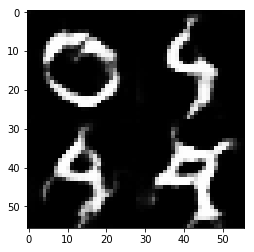

Epoch 2/2... Discriminator loss: 1.3198... Generator loss: 1.0936
Epoch 2/2... Discriminator loss: 1.3145... Generator loss: 0.8937
Epoch 2/2... Discriminator loss: 1.2351... Generator loss: 1.1067
Epoch 2/2... Discriminator loss: 1.2483... Generator loss: 0.8605
Epoch 2/2... Discriminator loss: 1.4434... Generator loss: 0.8727
Epoch 2/2... Discriminator loss: 1.4869... Generator loss: 1.0577
Epoch 2/2... Discriminator loss: 1.2661... Generator loss: 1.0892
Epoch 2/2... Discriminator loss: 1.3199... Generator loss: 1.0462
Epoch 2/2... Discriminator loss: 1.2716... Generator loss: 1.0252
Epoch 2/2... Discriminator loss: 1.3745... Generator loss: 0.8030
Epoch 2/2... Discriminator loss: 1.3630... Generator loss: 0.9078
Epoch 2/2... Discriminator loss: 1.2841... Generator loss: 0.8329
Epoch 2/2... Discriminator loss: 1.2872... Generator loss: 1.0132
Epoch 2/2... Discriminator loss: 1.3497... Generator loss: 0.6415
Epoch 2/2... Discriminator loss: 1.1780... Generator loss: 1.0643
Epoch 2/2.

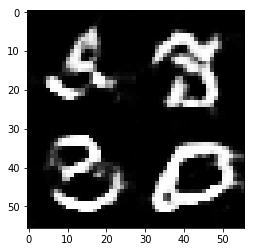

Epoch 2/2... Discriminator loss: 1.2332... Generator loss: 1.0429
Epoch 2/2... Discriminator loss: 1.3970... Generator loss: 0.9949
Epoch 2/2... Discriminator loss: 1.3305... Generator loss: 0.9645
Epoch 2/2... Discriminator loss: 1.4301... Generator loss: 0.9924
Epoch 2/2... Discriminator loss: 1.1948... Generator loss: 0.7887
Epoch 2/2... Discriminator loss: 1.4353... Generator loss: 1.3684
Epoch 2/2... Discriminator loss: 1.2908... Generator loss: 0.8057
Epoch 2/2... Discriminator loss: 1.3542... Generator loss: 1.0157
Epoch 2/2... Discriminator loss: 1.3258... Generator loss: 0.7954
Epoch 2/2... Discriminator loss: 1.3131... Generator loss: 1.0903
Epoch 2/2... Discriminator loss: 1.4831... Generator loss: 0.9273
Epoch 2/2... Discriminator loss: 1.6625... Generator loss: 0.7589
Epoch 2/2... Discriminator loss: 1.2584... Generator loss: 0.9167
Epoch 2/2... Discriminator loss: 1.4480... Generator loss: 1.0618
Epoch 2/2... Discriminator loss: 1.1736... Generator loss: 1.4067
Epoch 2/2.

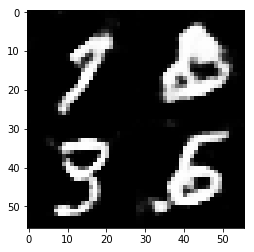

Epoch 2/2... Discriminator loss: 1.5064... Generator loss: 0.7898
Epoch 2/2... Discriminator loss: 1.2957... Generator loss: 1.2969
Epoch 2/2... Discriminator loss: 1.4618... Generator loss: 0.9375
Epoch 2/2... Discriminator loss: 1.3213... Generator loss: 1.1134
Epoch 2/2... Discriminator loss: 1.4298... Generator loss: 0.7381
Epoch 2/2... Discriminator loss: 1.2736... Generator loss: 0.9944
Epoch 2/2... Discriminator loss: 1.2529... Generator loss: 0.8490
Epoch 2/2... Discriminator loss: 1.1800... Generator loss: 0.8574
Epoch 2/2... Discriminator loss: 1.3460... Generator loss: 1.0345
Epoch 2/2... Discriminator loss: 1.3413... Generator loss: 1.0618
Epoch 2/2... Discriminator loss: 1.3512... Generator loss: 0.9880
Epoch 2/2... Discriminator loss: 1.3303... Generator loss: 1.1410
Epoch 2/2... Discriminator loss: 1.4075... Generator loss: 0.8587
Epoch 2/2... Discriminator loss: 1.5317... Generator loss: 1.0273
Epoch 2/2... Discriminator loss: 1.3920... Generator loss: 1.0799
Epoch 2/2.

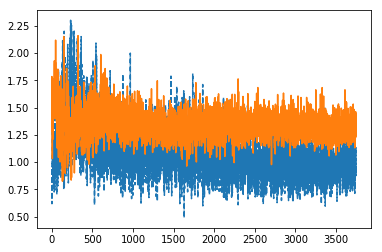

In [26]:
batch_size = 32
z_dim = 50
learning_rate = 0.0001 #0.001
beta1 = 0.01 #0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

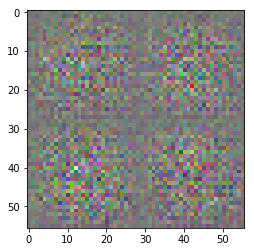

Epoch 1/1... Discriminator loss: 2.1930... Generator loss: 0.6718
Epoch 1/1... Discriminator loss: 2.1333... Generator loss: 0.4717
Epoch 1/1... Discriminator loss: 2.0753... Generator loss: 0.5333
Epoch 1/1... Discriminator loss: 1.8327... Generator loss: 0.6573
Epoch 1/1... Discriminator loss: 1.9150... Generator loss: 0.7741
Epoch 1/1... Discriminator loss: 1.8029... Generator loss: 0.8455
Epoch 1/1... Discriminator loss: 1.7918... Generator loss: 0.8091
Epoch 1/1... Discriminator loss: 1.8400... Generator loss: 0.7733
Epoch 1/1... Discriminator loss: 1.5827... Generator loss: 1.0860
Epoch 1/1... Discriminator loss: 1.7976... Generator loss: 0.9380
Epoch 1/1... Discriminator loss: 1.5959... Generator loss: 1.0271
Epoch 1/1... Discriminator loss: 1.6333... Generator loss: 1.0412
Epoch 1/1... Discriminator loss: 1.4677... Generator loss: 1.2427
Epoch 1/1... Discriminator loss: 1.5653... Generator loss: 1.2109
Epoch 1/1... Discriminator loss: 1.4604... Generator loss: 1.4077
Epoch 1/1.

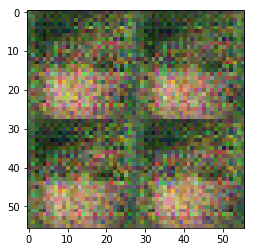

Epoch 1/1... Discriminator loss: 1.2815... Generator loss: 1.3966
Epoch 1/1... Discriminator loss: 1.0819... Generator loss: 1.4674
Epoch 1/1... Discriminator loss: 1.1499... Generator loss: 1.6042
Epoch 1/1... Discriminator loss: 1.1556... Generator loss: 1.4985
Epoch 1/1... Discriminator loss: 1.1574... Generator loss: 1.5707
Epoch 1/1... Discriminator loss: 0.9714... Generator loss: 2.2857
Epoch 1/1... Discriminator loss: 1.3140... Generator loss: 1.5137
Epoch 1/1... Discriminator loss: 1.0476... Generator loss: 1.7159
Epoch 1/1... Discriminator loss: 1.1229... Generator loss: 1.8709
Epoch 1/1... Discriminator loss: 1.0216... Generator loss: 2.1419
Epoch 1/1... Discriminator loss: 1.2482... Generator loss: 1.5564
Epoch 1/1... Discriminator loss: 1.1160... Generator loss: 2.3437
Epoch 1/1... Discriminator loss: 1.1325... Generator loss: 1.5075
Epoch 1/1... Discriminator loss: 1.1768... Generator loss: 1.4109
Epoch 1/1... Discriminator loss: 1.1200... Generator loss: 1.8860
Epoch 1/1.

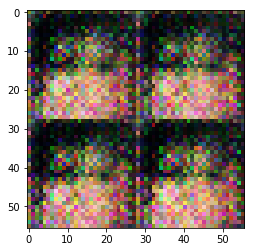

Epoch 1/1... Discriminator loss: 0.9508... Generator loss: 1.9317
Epoch 1/1... Discriminator loss: 0.8075... Generator loss: 1.9939
Epoch 1/1... Discriminator loss: 1.0095... Generator loss: 1.7434
Epoch 1/1... Discriminator loss: 0.7271... Generator loss: 2.3221
Epoch 1/1... Discriminator loss: 0.9611... Generator loss: 1.6270
Epoch 1/1... Discriminator loss: 0.9714... Generator loss: 1.9133
Epoch 1/1... Discriminator loss: 0.9753... Generator loss: 1.6561
Epoch 1/1... Discriminator loss: 0.9002... Generator loss: 2.0930
Epoch 1/1... Discriminator loss: 0.8660... Generator loss: 2.0538
Epoch 1/1... Discriminator loss: 0.8797... Generator loss: 2.0376
Epoch 1/1... Discriminator loss: 0.9967... Generator loss: 2.2140
Epoch 1/1... Discriminator loss: 1.2305... Generator loss: 1.4425
Epoch 1/1... Discriminator loss: 1.2258... Generator loss: 1.2968
Epoch 1/1... Discriminator loss: 1.2327... Generator loss: 1.2987
Epoch 1/1... Discriminator loss: 1.2699... Generator loss: 1.6562
Epoch 1/1.

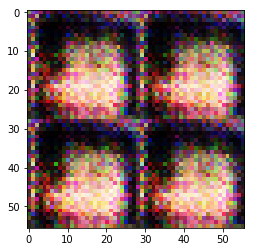

Epoch 1/1... Discriminator loss: 0.6003... Generator loss: 2.7813
Epoch 1/1... Discriminator loss: 0.7546... Generator loss: 2.1794
Epoch 1/1... Discriminator loss: 0.6589... Generator loss: 2.2706
Epoch 1/1... Discriminator loss: 0.7243... Generator loss: 2.4857
Epoch 1/1... Discriminator loss: 0.7942... Generator loss: 2.2336
Epoch 1/1... Discriminator loss: 0.6891... Generator loss: 2.8547
Epoch 1/1... Discriminator loss: 0.6757... Generator loss: 2.2971
Epoch 1/1... Discriminator loss: 0.7775... Generator loss: 2.2846
Epoch 1/1... Discriminator loss: 0.9163... Generator loss: 2.1886
Epoch 1/1... Discriminator loss: 0.9498... Generator loss: 1.8956
Epoch 1/1... Discriminator loss: 0.9204... Generator loss: 2.6189
Epoch 1/1... Discriminator loss: 0.7988... Generator loss: 2.0749
Epoch 1/1... Discriminator loss: 0.9289... Generator loss: 1.4842
Epoch 1/1... Discriminator loss: 0.7764... Generator loss: 2.5295
Epoch 1/1... Discriminator loss: 0.7181... Generator loss: 2.2555
Epoch 1/1.

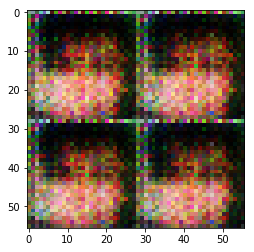

Epoch 1/1... Discriminator loss: 0.6322... Generator loss: 2.7382
Epoch 1/1... Discriminator loss: 0.6377... Generator loss: 2.5000
Epoch 1/1... Discriminator loss: 0.5844... Generator loss: 2.4979
Epoch 1/1... Discriminator loss: 0.6238... Generator loss: 2.8684
Epoch 1/1... Discriminator loss: 0.6150... Generator loss: 2.5352
Epoch 1/1... Discriminator loss: 0.7286... Generator loss: 2.5540
Epoch 1/1... Discriminator loss: 0.5827... Generator loss: 2.8396
Epoch 1/1... Discriminator loss: 0.6232... Generator loss: 2.2361
Epoch 1/1... Discriminator loss: 0.6879... Generator loss: 2.6826
Epoch 1/1... Discriminator loss: 0.6718... Generator loss: 2.0798
Epoch 1/1... Discriminator loss: 0.7457... Generator loss: 2.3715
Epoch 1/1... Discriminator loss: 0.6635... Generator loss: 2.3938
Epoch 1/1... Discriminator loss: 0.6629... Generator loss: 2.6494
Epoch 1/1... Discriminator loss: 0.8022... Generator loss: 1.9480
Epoch 1/1... Discriminator loss: 0.8774... Generator loss: 2.3826
Epoch 1/1.

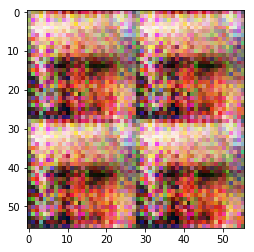

Epoch 1/1... Discriminator loss: 0.6650... Generator loss: 2.7124
Epoch 1/1... Discriminator loss: 0.8150... Generator loss: 1.7349
Epoch 1/1... Discriminator loss: 0.6285... Generator loss: 2.7809
Epoch 1/1... Discriminator loss: 0.7885... Generator loss: 2.1371
Epoch 1/1... Discriminator loss: 0.6755... Generator loss: 3.2559
Epoch 1/1... Discriminator loss: 0.5991... Generator loss: 3.1880
Epoch 1/1... Discriminator loss: 0.5484... Generator loss: 3.3777
Epoch 1/1... Discriminator loss: 0.5457... Generator loss: 2.8033
Epoch 1/1... Discriminator loss: 0.6489... Generator loss: 2.9910
Epoch 1/1... Discriminator loss: 0.6043... Generator loss: 3.1049
Epoch 1/1... Discriminator loss: 0.6334... Generator loss: 2.5160
Epoch 1/1... Discriminator loss: 0.5788... Generator loss: 2.8735
Epoch 1/1... Discriminator loss: 0.6512... Generator loss: 2.6270
Epoch 1/1... Discriminator loss: 0.5626... Generator loss: 3.0582
Epoch 1/1... Discriminator loss: 0.6079... Generator loss: 3.1360
Epoch 1/1.

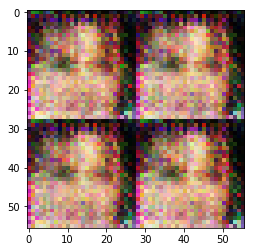

Epoch 1/1... Discriminator loss: 0.4756... Generator loss: 3.1731
Epoch 1/1... Discriminator loss: 0.6508... Generator loss: 2.4239
Epoch 1/1... Discriminator loss: 0.5962... Generator loss: 2.6730
Epoch 1/1... Discriminator loss: 0.6410... Generator loss: 3.0909
Epoch 1/1... Discriminator loss: 0.6033... Generator loss: 2.2142
Epoch 1/1... Discriminator loss: 0.6214... Generator loss: 2.4728
Epoch 1/1... Discriminator loss: 0.7798... Generator loss: 2.5956
Epoch 1/1... Discriminator loss: 0.6706... Generator loss: 2.3745
Epoch 1/1... Discriminator loss: 0.6200... Generator loss: 2.3581
Epoch 1/1... Discriminator loss: 0.5976... Generator loss: 2.8910
Epoch 1/1... Discriminator loss: 0.5962... Generator loss: 2.9424
Epoch 1/1... Discriminator loss: 0.5636... Generator loss: 2.7613
Epoch 1/1... Discriminator loss: 0.5884... Generator loss: 2.9002
Epoch 1/1... Discriminator loss: 0.5739... Generator loss: 2.9618
Epoch 1/1... Discriminator loss: 0.6056... Generator loss: 2.8751
Epoch 1/1.

In [ ]:
batch_size = 64
z_dim = 200
learning_rate = 0.0001
beta1 = 0.01
#Just checking in, DT

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.